##### 0 data preprocessing and visulization

In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from scipy.interpolate import interp1d

In [282]:
bonds = pd.read_excel('C1Data.xlsx', sheet_name='Bonds', index_col='ISSUE_ID')
bonds.columns = ['transactionDate', 'price', 'maturityDate', 'spread',
       'offeringDate', 'principal', 'interestFrequency', 'couponRate',
       'rating', 'securityLevel']

yield_curve = pd.read_excel('C1Data.xlsx', sheet_name='YieldCurve')
yield_curve = yield_curve.iloc[:-1]   #remove last incorrect row
yield_curve['year'] = (yield_curve.index + 1) * 0.25  #index starts from 0 to # rows-1
yield_curve = yield_curve.set_index('year')
yield_curve = yield_curve.drop(columns='Date')
yield_curve.columns = ['2024-05-31', '2025-01-13']  #change col names
yield_curve = yield_curve.astype({'2025-01-13': 'float64'})  #convert incorrect data type

In [283]:
# US yield curve
# https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2024

yield_us = pd.read_csv('daily-treasury-rates.csv')
yield_us = yield_us[yield_us.Date=='05/31/2024']
yield_us = yield_us.iloc[:, 1:]
yield_us.columns = [1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
yield_us = yield_us.transpose()

/var/folders/33/qv3yf4892xld1btchk4myrjc0000gn/T/ipykernel_33076/891030078.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=20)


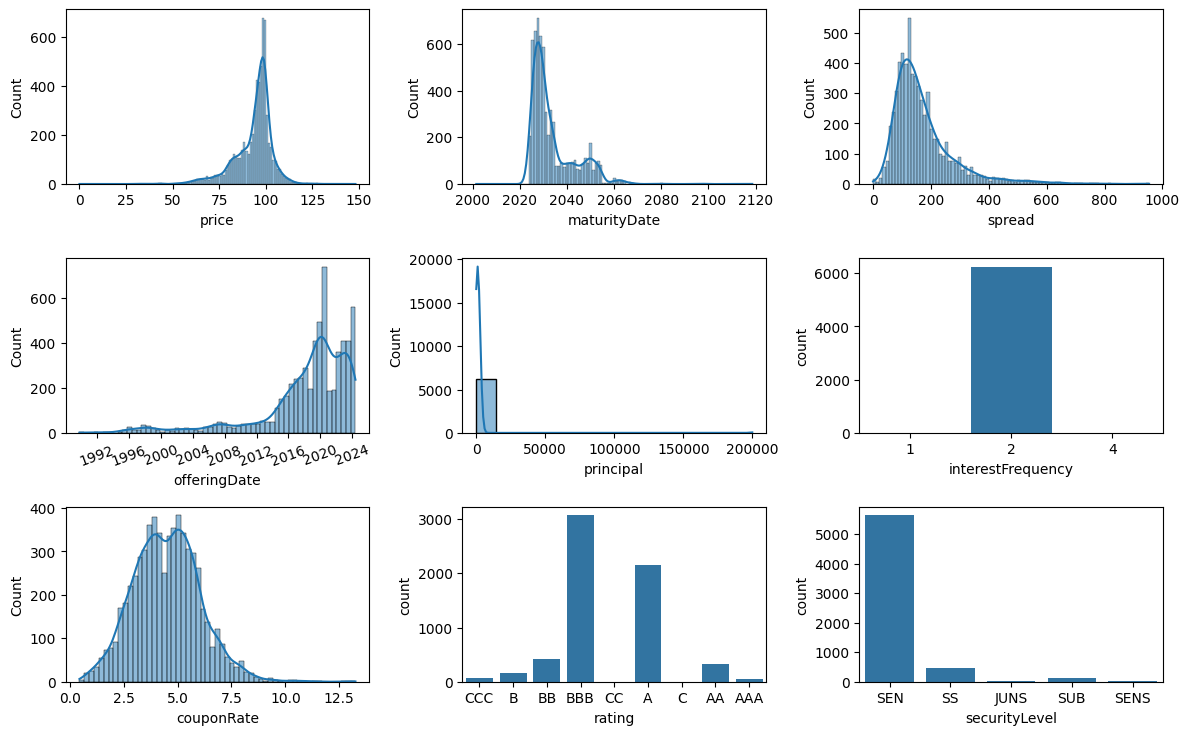

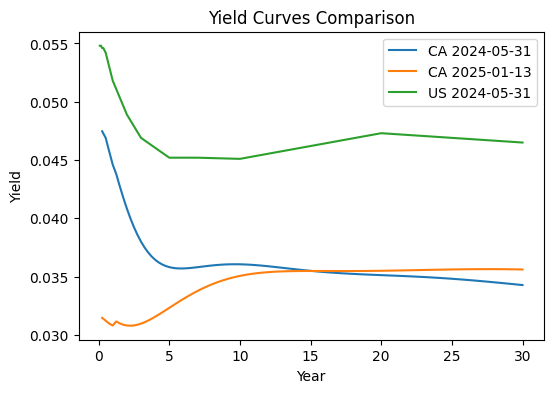

In [284]:
# plot variables in 'bonds' 
categorical_cols = ['interestFrequency', 'rating', 'securityLevel']
numeric_cols = [i for i in bonds.columns]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 12))
for i, column in enumerate(bonds.columns[1:]):
    if column in categorical_cols:
        sns.countplot(data=bonds, x=column, ax=axes[i//3, i%3])  #row, column
    else:
        sns.histplot(data=bonds, x=column, kde=True, ax=axes[i//3, i%3])

    # rotate ticks
    if column in ['offeringDate']:
        axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=20)

for j in range(i + 1, 15):
    fig.delaxes(axes[j//3, j%3])  #delete empty subplots
plt.tight_layout()
plt.show()

# plot yield curve
plt.figure(figsize=(6,4))
plt.plot(yield_curve.index, yield_curve['2024-05-31'], label='CA 2024-05-31')
plt.plot(yield_curve.index, yield_curve['2025-01-13'], label='CA 2025-01-13')
plt.plot(yield_us.index, yield_us/100, label='US 2024-05-31')
plt.xlabel('Year')
plt.ylabel('Yield')
plt.legend()
plt.title("Yield Curves Comparison")
plt.grid(False)

In [285]:
bonds.head(n=3)

,transactionDate,price,maturityDate,spread,offeringDate,principal,interestFrequency,couponRate,rating,securityLevel
ISSUE_ID,,,,,,,,,,
1080888,2024-05-31,108.867,2028-12-31,954.0,2023-04-25,1000,2,12.75,CCC,SEN
840849,2024-05-31,103.375,2027-08-01,952.0,2019-07-31,1000,2,10.75,CCC,SEN
853359,2024-05-31,100.140,2025-04-15,940.0,2019-09-27,1000,2,11.00,CCC,SEN


In [286]:
yield_curve.head()

,2024-05-31,2025-01-13
year,,
0.25,0.047468,0.031470
0.50,0.046900,0.031224
0.75,0.045734,0.030977
1.00,0.044603,0.030813
1.25,0.043789,0.031161


##### Question 1 & 2: bond pricing using different yield curves

according to the bond pricing formula, we need to know 
1) coupon which is couponRate / interestFrequency $\times$ principal; <br>
2) coupon payment schedule, from matrurity date to "today" (transaction date), then reverse the list; <br>
3) risk free rate: we are required to use Canadian risk free rate on the transaction date (05-31-2024); <br>
4) spread, which is the spread column of the Bonds sheet

Coupon amount

In [287]:
bonds['coupon'] = bonds.couponRate/100 * bonds.principal / bonds.interestFrequency

Coupon payment

In [288]:
def count_remaining_coupons(df):
    ''' Compute remaining number of coupons for each bond '''
    
    # generate all coupon payment dates
    coupon_dates = []
    delta = 12 // df.interestFrequency
    end = df.maturityDate
    
    while end > df.transactionDate:
        coupon_dates.append(end)
        end -= pd.DateOffset(months=delta)
    
    coupon_dates.reverse()
    numCoupons = len(coupon_dates)

    return pd.Series([coupon_dates, numCoupons])

bonds[['coupon_dates', 'numCoupons']] = bonds.apply(count_remaining_coupons, axis=1)

Interpolate the risk-free rate

In [289]:
def get_rf(df, yield_curve_date='2024-05-31'):
    today = df.transactionDate 
    #express the date difference in days and then convert to year 
    delta = [(date-today).days /365 for date in df.coupon_dates]  
    
    # use 'quadratic' because when using 'cubic' some interpolated interest rates are negative 
    interpolate_func = interp1d(yield_curve.index, yield_curve[yield_curve_date], fill_value="extrapolate", kind='quadratic') 
    rf = interpolate_func(delta)

    # t: exponents in the pricing formula
    # the unit is not year, but 'period'
    t = np.arange(df.numCoupons, dtype='float64')
    t += (df.coupon_dates[0]-today).days/(365/df.interestFrequency) if len(df.coupon_dates)>0 else 0
    
    return pd.Series([rf, t])

bonds[['rf', 't']] = bonds.apply(get_rf, axis=1)    

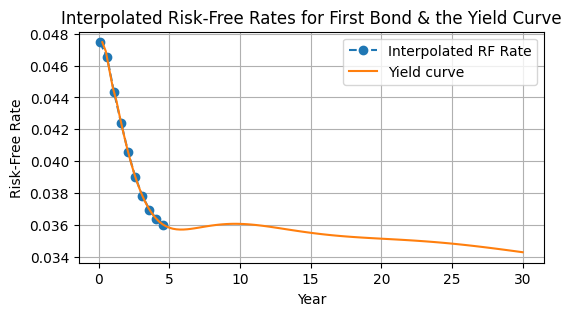

In [290]:
# visualize the interpolated risk-free rates for the first bond

# extract the first bond's rf & t 
rf = bonds.iloc[0].rf
t = bonds.iloc[0].t

# t's unit is period
# here 1 t = 0.5 yr 
# because the first bond's payment frequency is 2
t = t * 0.5

plt.figure(figsize=(6,3))
plt.plot(t, rf, marker='o', linestyle = '--', label="Interpolated RF Rate")
plt.plot(yield_curve.index, yield_curve['2024-05-31'], linestyle='-', label='Yield curve')
plt.xlabel("Year")
plt.ylabel("Risk-Free Rate")
plt.title("Interpolated Risk-Free Rates for First Bond & the Yield Curve")
plt.grid(True)
plt.legend()
plt.show()

In [291]:
t

array([0.08219178, 0.58219178, 1.08219178, 1.58219178, 2.08219178,
       2.58219178, 3.08219178, 3.58219178, 4.08219178, 4.58219178])

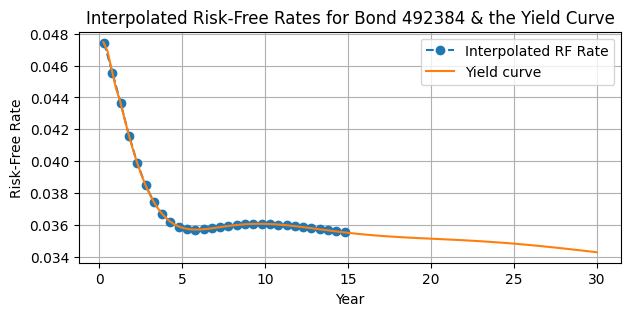

In [292]:
# bond with issue_id 492384

# extract the bond's rf & t 
rf = bonds.loc[492384].rf
t = bonds.loc[492384].t

# t's unit is period
# here 1 t = 0.5 yr 
# because the this bond's payment frequency is also 2
t = t * 0.5

plt.figure(figsize=(7,3))
plt.plot(t, rf, marker='o', linestyle = '--', label="Interpolated RF Rate")
plt.plot(yield_curve.index, yield_curve['2024-05-31'], linestyle='-', label='Yield curve')
plt.xlabel("Year")
plt.ylabel("Risk-Free Rate")
plt.title("Interpolated Risk-Free Rates for Bond 492384 & the Yield Curve")
plt.grid(True)
plt.legend()
plt.show()

Discount the cashflows

In [293]:
def discount_cf(df, rf='rf'):
    # handle edge case
    if df.numCoupons == 0:
        return 0
    
    # generate cashflows
    cfs = np.repeat(df.coupon, df.numCoupons)
    cfs[df.numCoupons-1] += df.principal

    ts = df.t   

    # sum a bond's rf and its spread
    # both rates are annulized so there should be no issue here
    rs = df[rf] + df.spread/10000    #basis points conversion

    # r/df.interestFrequency: adjust annulized rates to period-wise rates
    # so this fits the pricing formula
    discounted_cf = [cf / (1 + r/df.interestFrequency)**t for cf, r, t in zip(cfs, rs, ts)]
    return sum(discounted_cf) / df.principal * 100      #express price as a % of the principal

bonds['price2'] = bonds.apply(discount_cf, axis=1)

In [294]:
bonds[['price', 'price2']].head()

,price,price2
ISSUE_ID,,
1080888,108.867,103.735989
840849,103.375,96.990908
853359,100.140,99.006739
920565,103.116,94.663889
903365,100.250,96.234412


Compare the two prices 

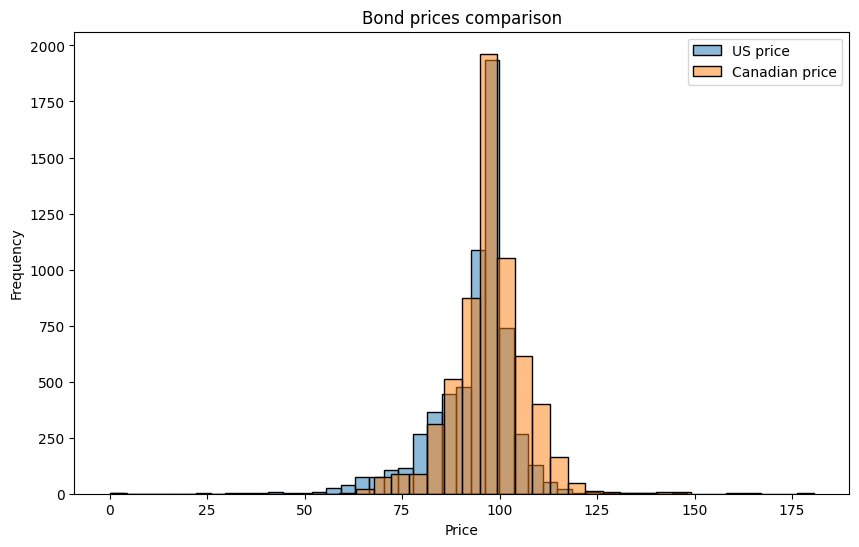

In [295]:
# vis 1. histplot
plt.figure(figsize=(10,6))
sns.histplot(bonds.price, bins=40, kde=False, alpha=0.5, label='US price',edgecolor='black')
sns.histplot(bonds.price2, bins=40, kde=False, alpha=0.5, label='Canadian price', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Bond prices comparison')
plt.legend()
plt.show()

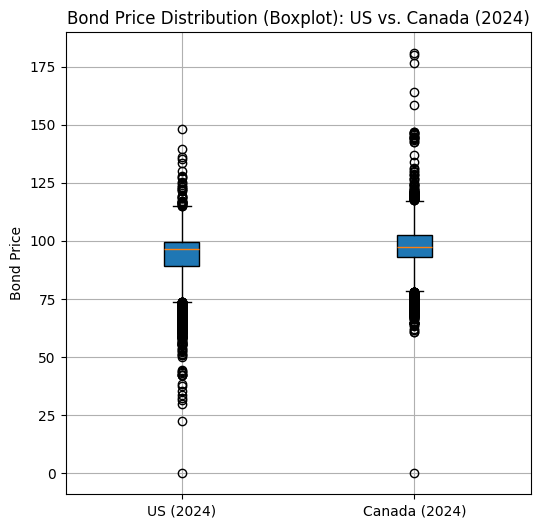

In [296]:
# vis 2. boxplot
plt.figure(figsize=(6,6))
plt.boxplot(
    [bonds["price"], bonds["price2"]],
    labels=["US (2024)", "Canada (2024)"],
    patch_artist=True)

plt.ylabel("Bond Price")
plt.title("Bond Price Distribution (Boxplot): US vs. Canada (2024)")
plt.grid(True)
plt.show()

0.8093260938997126 - proportion of bonds priced higher due to CA rates 
3.861954457653701 - average price difference


<Axes: ylabel='Count'>

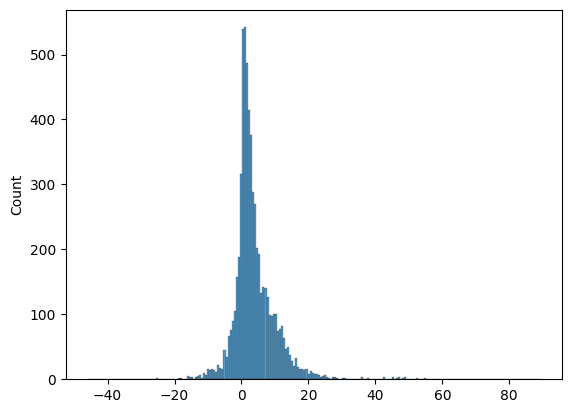

In [297]:
# numeric
print(np.mean(bonds.price2 > bonds.price), '- proportion of bonds priced higher due to CA rates ')
print(np.mean(bonds.price2 - bonds.price), '- average price difference')
sns.histplot(bonds.price2 - bonds.price)

Calculate the price on Jan 13, 2025, & compare three prices

In [298]:
#re-calculate rf
bonds[['rf_0113', 't']] = bonds.apply(lambda df: get_rf(df, yield_curve_date='2025-01-13'), axis=1)  

# re-compute the price
bonds['price_0113'] = bonds.apply(lambda df: discount_cf(df, rf='rf_0113'), axis=1)

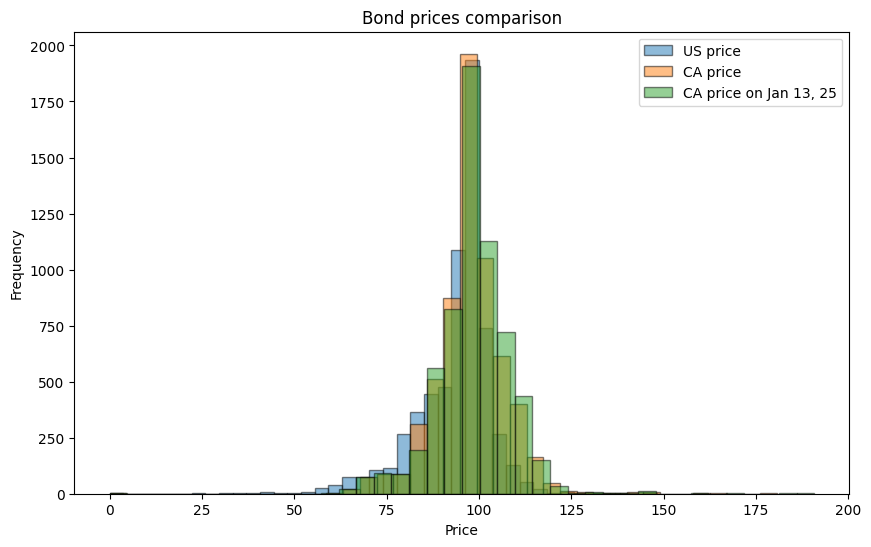

In [299]:
# compare three prices. histplot
plt.figure(figsize=(10,6))
plt.hist(bonds.price, bins=40, alpha=0.5, label='US price',edgecolor='black')
plt.hist(bonds.price2, bins=40, alpha=0.5, label='CA price', edgecolor='black', color='#ff7f0e')
plt.hist(bonds.price_0113, bins=40, alpha=0.5, label='CA price on Jan 13, 25', edgecolor='black', color='#2ca02c')

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Bond prices comparison')
plt.legend()
plt.show()

0.884062599808368 - proportion of bonds priced higher due to even lower CA rates 
1.176668836899182 - average price difference


<Axes: ylabel='Count'>

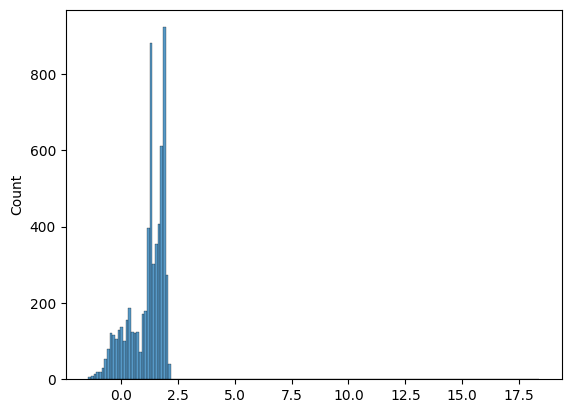

In [300]:
# numeric
print(np.mean(bonds.price_0113 > bonds.price2), '- proportion of bonds priced higher due to even lower CA rates ')
print(np.mean(bonds.price_0113 - bonds.price2), '- average price difference')
sns.histplot(bonds.price_0113 - bonds.price2)

##### Question 3: calculate the capital requirements of these bonds

Compute LGD and EAD

In [301]:
# according to 5.4.1 (ii), OSFI guideline
# suggested:
# LGD of SS (Senior Secured) should be more than 0
level_to_LGD = {
    'JUN':0.75, 'JUNS':0.75, 'SEN':0.4, 'SENS':0.75,
    'SS':0.2, 'SUB':0.75
}

In [302]:
def calculate_EAD(df, price='price'):
    ''' args: price: 'price', 'price2', or 'price_0113 '''
    EAD = df[price] / 100 * df.principal
    return EAD

bonds['EAD'] = bonds.apply(lambda df: calculate_EAD(df, 'price'), axis=1)

In [303]:
bonds.EAD

ISSUE_ID
1080888    1088.67
840849     1033.75
853359     1001.40
920565     1031.16
903365     1002.50
            ...   
1132686     993.91
1109470    1011.15
1132682     999.11
1132674     997.82
171675     1148.79
Name: EAD, Length: 6262, dtype: float64

PD

![alt text](image.png)

PD = X ~ lognormal(mu, sigma^2) <br>
*mu_x*: E(PD) = exp(mu + 1/2 * sigma^2) <br>
Var(PD) = (exp(sigma^2) - 1) * exp(2*mu + sigma^2) <br>
*sigma_x*: SD(PD) <br>
*mu_x* and *sigma_x* are known from the table, need to compute mu and sigma^2 such that *mu_x* and *sigma_x* match the known values

In [ ]:
# rating: (weighted long-term average, standard deviation)
# these values correspond to the table and they are expressed as percentages ?
rating_default_rate = {'AAA':(0,0), 'AA':(0.02, 0.06), 'A':(0.05,0.1),
                  'BBB':(0.14,0.25), 'BB':(0.57,0.96), 'B':(2.98,3.23),
                  'CCC':(25.98,11.73), 'CC':(25.98,11.73), 'C':(25.98,11.73)}

num_sim = 10000
rng = np.random.default_rng(1)
z_values = rng.standard_normal(num_sim)

# row is each realization, columns are ratings
PD_sim = pd.DataFrame(index=range(num_sim),
                      columns=list(rating_default_rate.keys()),
                      dtype=float)

# for AAA bond, treat its PD as a constant==0
PD_sim['AAA'] = 0 

for col in PD_sim.columns[1:]:  
    mu_x, sigma_x = rating_default_rate[col] 
    mu_x, sigma_x  = mu_x / 100, sigma_x / 100
    mu = np.log(mu_x**2 / np.sqrt(mu_x**2 + sigma_x**2))
    sigma2 = np.log(1 + sigma_x**2/mu_x**2)
    sigma = np.sqrt(sigma2)
    PD_sim[col] = np.exp(mu + sigma * z_values)

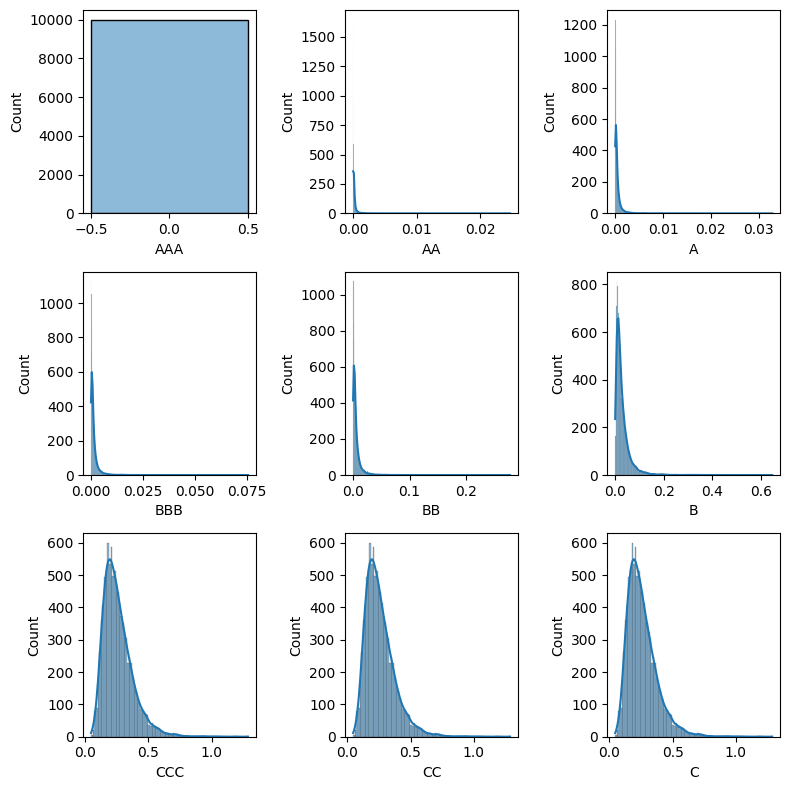

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
for i, column in enumerate(PD_sim.columns):
        sns.histplot(data=PD_sim, x=column, kde=True, ax=axes[i//3, i%3]) 
plt.tight_layout()
plt.show()

In [115]:
# trim the PD values that are greater than 1
PD_sim[PD_sim >1] = 1

Effective maturity M

In [117]:
# compute the effective maturity for the bonds
# according to 5.4.1 (iv) 133, OSFI guideline
def get_maturity(df):
    # handle edge case
    if df.numCoupons == 0:
        return 0
    
    # generate cashflows
    cfs = np.repeat(df.coupon, df.numCoupons)
    cfs[df.numCoupons-1] += df.principal
    
    numerator = np.sum(df.t * cfs)
    denominator = np.sum(cfs)
    m = numerator / denominator
    if m < 1:
        m = 1
    if m > 5:
        m = 5
    return m

bonds['maturity'] = bonds.apply(get_maturity, axis=1)

$$
K = LGD \cdot \left\{ N\left( \sqrt{\frac{1}{1-R}} \cdot N^{-1}(PD) + \sqrt{\frac{R}{1-R}} \cdot N^{-1}(0.999) \right) - PD \right\} \left( \frac{1 + (M - 2.5)b}{1 - 1.5b}\right)
$$

Corporate and sovereign exposures $ R = 0.12 \left( \frac{1 - e^{-50PD}}{1 - e^{-50}} \right) + 0.24 \left( 1 - \frac{1 - e^{-50PD}}{1 - e^{-50}} \right)$

In [118]:
def cal_capital_requirement(df):
    from scipy.stats import norm

    rating= df.rating
    PD = PD_sim[rating]
    PD[PD < 0.0003] = 0.0003  #PD floor of Basel III 
    
    b = 0.11852 - 0.05478 * np.log(PD)
    maturity = df.maturity
    adjustment = (1+(maturity-2.5)*b) / (1-1.5*b)
    
    LGD = level_to_LGD.get(df.securityLevel)
    
    R = 0.12 * ((1 - np.exp(-50*PD)) / (1 - np.exp(-50)))  \
        + 0.24 * (1 - ((1 - np.exp(-50*PD)) / (1 - np.exp(-50))))    
    
    # ppf is inverse of cdf
    xx = np.sqrt(1/(1 - R)) * norm.ppf(PD) + np.sqrt(R/(1 - R)) * norm.ppf(0.999)
    K = (norm.cdf(xx) - PD) * LGD * adjustment
    reg_cap = K * df.EAD 
    return reg_cap

In [119]:
# also calculate provision
def cal_provision(df):
    rating= df.rating
    PD = PD_sim[rating]
    PD[PD < 0.0003] = 0.0003  #PD floor of Basel III 
    
    b = 0.11852 - 0.05478 * np.log(PD)
    maturity = df.maturity
    adjustment = (1+(maturity-2.5)*b) / (1-1.5*b)
    
    LGD = level_to_LGD.get(df.securityLevel) 
    
    K = PD * LGD  * adjustment
    provision = K * df.EAD
    return provision

Calculate the capital requirement & provision for each bond

In [120]:
reg_cap_for_each_bond = bonds.apply(cal_capital_requirement, axis=1)

/var/folders/33/qv3yf4892xld1btchk4myrjc0000gn/T/ipykernel_33076/546915034.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  PD[PD < 0.0003] = 0.0003  #PD floor of Basel III


In [121]:
provision_for_each_bond = bonds.apply(cal_provision, axis=1)

In [83]:
'''
#an example 
PD= PD_sim['BBB']
print('PD < 0.0003:\n', PD[PD < 0.0003])
print('logPD:\n', np.log(PD))
b = 0.11852 - 0.05478 * np.log(PD)
print('b\n', b)
maturity = 7
adjustment = (1+(maturity-2.5)*b) / (1-1.5*b)
print(adjustment)
LGD = level_to_LGD['SEN']
print(LGD)
R = 0.12 * ((1 - np.exp(-50 * PD)) / (1 - np.exp(-50)))  \
        + 0.24 * (1 - ((1 - np.exp(-50 * PD)) / (1 - np.exp(-50)))) 
print(R)
from scipy.stats import norm
## generate many NaNs due to norm.ppf(PD)
xx = np.sqrt(1/(1 - R)) * norm.ppf(PD) + np.sqrt(R/(1 - R)) * norm.ppf(0.999)
print(xx)
K = norm.cdf(xx) - PD
print(K)
print(K * adjustment)
bonds_test = bonds.iloc[0:2,:]
bonds_test
bonds_test.apply(cal_capital_requirement, axis=1)
'''

"\n#an example \nPD= PD_sim['BBB']\nprint('PD < 0.0003:\n', PD[PD < 0.0003])\nprint('logPD:\n', np.log(PD))\nb = 0.11852 - 0.05478 * np.log(PD)\nprint('b\n', b)\nmaturity = 7\nadjustment = (1+(maturity-2.5)*b) / (1-1.5*b)\nprint(adjustment)\nLGD = level_to_LGD['SEN']\nprint(LGD)\nR = 0.12 * ((1 - np.exp(-50 * PD)) / (1 - np.exp(-50)))          + 0.24 * (1 - ((1 - np.exp(-50 * PD)) / (1 - np.exp(-50)))) \nprint(R)\nfrom scipy.stats import norm\n## generate many NaNs due to norm.ppf(PD)\nxx = np.sqrt(1/(1 - R)) * norm.ppf(PD) + np.sqrt(R/(1 - R)) * norm.ppf(0.999)\nprint(xx)\nK = norm.cdf(xx) - PD\nprint(K)\nprint(K * adjustment)\nbonds_test = bonds.iloc[0:2,:]\nbonds_test\nbonds_test.apply(cal_capital_requirement, axis=1)\n"

Calculate the capital requirement & the provision for the portfolio. To do so, sum up the required capital/provisions for each individual bonds.

In [122]:
reg_cap_for_portfolio = reg_cap_for_each_bond.apply(sum, axis=0)

In [123]:
provision_for_portfolio = provision_for_each_bond.apply(sum, axis=0)

##### Question 3 d & e 
Histogram, descriptive statistics,  discussion about the behaviors of the portfolio, and conclusion from the analyses

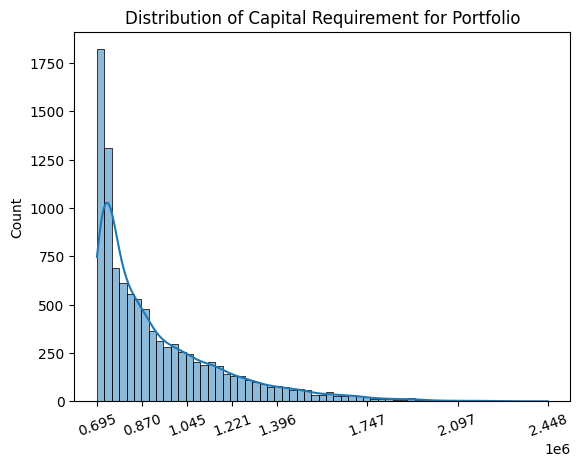

In [124]:
sns.histplot(data=reg_cap_for_portfolio, kde=True)

min_val = reg_cap_for_portfolio.min()
max_val = reg_cap_for_portfolio.max()
val_range = max_val - min_val
ticks1 = np.linspace(min_val, min_val + val_range*0.3, num=4)
ticks2 = np.linspace(min_val + val_range*0.4, max_val, num=4)
xticks = np.concatenate((ticks1, ticks2))
plt.xticks(xticks, rotation=20) 

plt.title("Distribution of Capital Requirement for Portfolio")
plt.show()

In [ ]:
# : Starts the formatting specification
# , Adds a thousands separator
# .2f Rounds the number to 2 decimal places
def cal_stats(df):
    from scipy.stats import skew, kurtosis
    stats_basic = df.describe()
    stats_extra = pd.Series({
        'sd': np.std(df, ddof=1),
        'skewness': skew(df),
        'kurtosis': kurtosis(df)
    })
    stats = pd.concat([stats_basic, stats_extra])
    stats['lb_95'] = df.mean() - 1.96 * df.std(ddof=1) / np.sqrt(len(df))
    stats['ub_95'] = df.mean() + 1.96 * df.std(ddof=1) / np.sqrt(len(df))    
    return stats

reg_cap_stats = cal_stats(reg_cap_for_portfolio)
print(reg_cap_stats.apply(lambda x: f'{x:,.2f}'))

count          10,000.00
mean          930,241.12
std           255,258.59
min           694,822.05
25%           728,987.78
50%           839,057.16
75%         1,040,498.99
max         2,448,006.24
sd            255,258.59
skewness            1.66
kurtosis            2.95
lb_95         925,238.05
ub_95         935,244.19
dtype: object


In [128]:
bonds_ead = bonds.EAD.sum()
print(f'{bonds_ead:,.2f} - EAD')
print(reg_cap_stats.loc['mean'] / bonds_ead, '- proportion of the average capital requirement')
print((reg_cap_stats.loc['lb_95']/ bonds_ead, reg_cap_stats['ub_95']/bonds_ead), '- proportion of the capital requirement bounds')

9,417,961.51 - EAD
0.0987730856307629 - proportion of the average capital requirement
(0.09824185937731751, 0.0993043118842083) - proportion of the capital requirement bounds


Skewness is greater than 0, i.e., positively skewed. This means most values are concentrated on the left with a few larger values on the right. Kurtosis is less than 3. This means extrme values are less likely than in a normal distribution; the tail is not heavy.

Out of 10,000 simulations, on average, regulatory capital required is 930,241.12.  The total exposure of the portfolio, EAD, is 9,417,961.51. The 95% confidence interval for the regulatory capital is [925,238.05, 935,244.19]. Dividing these two quantaties by EAD and multiply by 100, we get (9.82, 9.93). This means for $100 exposure to a portfolio of bonds, the bank needs to set aside $9.82 ~ $9.93 as economic capital.

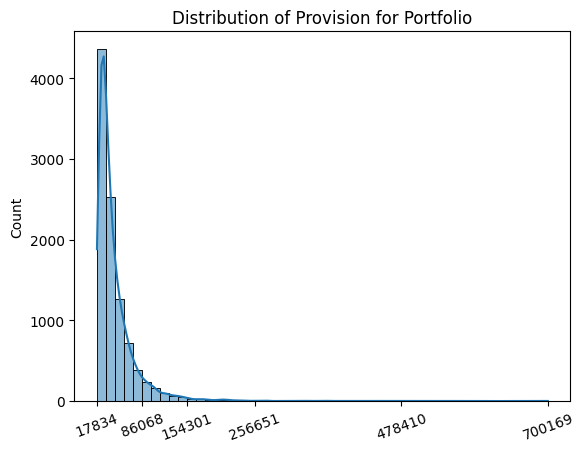

In [129]:
sns.histplot(data=provision_for_portfolio, kde=True, bins=50)

min_val = provision_for_portfolio.min()
max_val = provision_for_portfolio.max()
val_range = max_val - min_val
ticks1 = np.linspace(min_val, min_val + val_range*0.2, num=3)
ticks2 = np.linspace(min_val + val_range*0.35, max_val, num=3)
xticks = np.concatenate((ticks1, ticks2))
plt.xticks(xticks, rotation=20) 

plt.title("Distribution of Provision for Portfolio")
plt.show()

In [130]:
provision_stats = cal_stats(provision_for_portfolio)
print(provision_stats.apply(lambda x: f'{x:,.2f}'))

count        10,000.00
mean         44,350.56
std          33,323.97
min          17,834.45
25%          25,471.38
50%          34,070.18
75%          50,647.08
max         700,168.71
sd           33,323.97
skewness          5.23
kurtosis         53.43
lb_95        43,697.41
ub_95        45,003.71
dtype: object


In [131]:
print(f'{bonds_ead:,.2f} - EAD')
print(provision_stats.loc['mean'] / bonds_ead, '- proportion of the average provision')
print((provision_stats.loc['lb_95']/ bonds_ead, provision_stats['ub_95']/bonds_ead), '- proportion of provision bounds')

9,417,961.51 - EAD
0.004709146651055347 - proportion of the average provision
(0.004639795143418403, 0.004778498158692291) - proportion of provision bounds


Skewness is greater than 0, i.e., positively skewed. This means most values are concentrated on the left with a few larger values on the right. Kurtosis is much greater than 3. This means extrme values are more likely than in a normal distribution; the tail is very heavy.

Out of 10,000 simulations, on average, provision required is 44,350.56.  The total exposure of the portfolio, EAD, is 9,417,961.51. The 95% confidence interval for the provision is [43,697.41, 45,003.71]. Dividing these two quantaties by EAD and multiply by 100, we get (0.46, 0.48). This means for $100 exposure to a portfolio of bonds, the bank needs to set aside $0.46 ~ $0.48 as economic capital.

##### More analysis
We now analyze the contribution to regulatory capital by bonds of different ratings.

In [151]:
mean_regcap_for_each_bond = pd.DataFrame({
    'mean_regcap': reg_cap_for_each_bond.apply(np.nanmean, axis=1),
    'rating': bonds.rating})
mean_regcap_for_each_bond.head()

,mean_regcap,rating
ISSUE_ID,,
1080888,361.319360,CCC
840849,343.091927,CCC
853359,187.173511,CCC
920565,256.003785,B
903365,113.611466,B


In [152]:
df_grouped = mean_regcap_for_each_bond.groupby('rating').mean_regcap.agg(['sum', 'count'])
df_grouped.columns = ['mean_regcap_sum', 'num_bonds']

df_grouped['EAD_rating'] = bonds.groupby('rating').EAD.sum()
df_grouped['EAD_total'] = bonds_ead

df_grouped.head(n=10)

,mean_regcap_sum,num_bonds,EAD_rating,EAD_total
rating,,,,
A,260974.673253,2152,3.199972e+06,9.417962e+06
AA,22446.314308,330,3.006053e+05,9.417962e+06
AAA,3982.343436,57,5.205224e+04,9.417962e+06
B,27529.598600,153,1.410923e+05,9.417962e+06
BB,58632.251350,426,4.057554e+05,9.417962e+06
BBB,540709.073560,3069,5.263139e+06,9.417962e+06
C,427.929807,3,1.401560e+03,9.417962e+06
CC,99.568307,2,3.000100e+02,9.417962e+06
CCC,15439.366455,70,5.364360e+04,9.417962e+06


In [153]:
#df_grouped['proportion'] = df_grouped['mean_regcap_sum'] / df_grouped.EAD_total
#df_grouped.head(n=10)

df_grouped['proportion_rating'] = df_grouped['mean_regcap_sum'] / df_grouped.EAD_rating
df_grouped.head(n=10)

,mean_regcap_sum,num_bonds,EAD_rating,EAD_total,proportion_rating
rating,,,,,
A,260974.673253,2152,3.199972e+06,9.417962e+06,0.081555
AA,22446.314308,330,3.006053e+05,9.417962e+06,0.074670
AAA,3982.343436,57,5.205224e+04,9.417962e+06,0.076507
B,27529.598600,153,1.410923e+05,9.417962e+06,0.195118
BB,58632.251350,426,4.057554e+05,9.417962e+06,0.144501
BBB,540709.073560,3069,5.263139e+06,9.417962e+06,0.102735
C,427.929807,3,1.401560e+03,9.417962e+06,0.305324
CC,99.568307,2,3.000100e+02,9.417962e+06,0.331883
CCC,15439.366455,70,5.364360e+04,9.417962e+06,0.287814


/var/folders/33/qv3yf4892xld1btchk4myrjc0000gn/T/ipykernel_33076/91419008.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y=yy, data=df_grouped, palette="viridis")


<Axes: xlabel='rating', ylabel='None'>

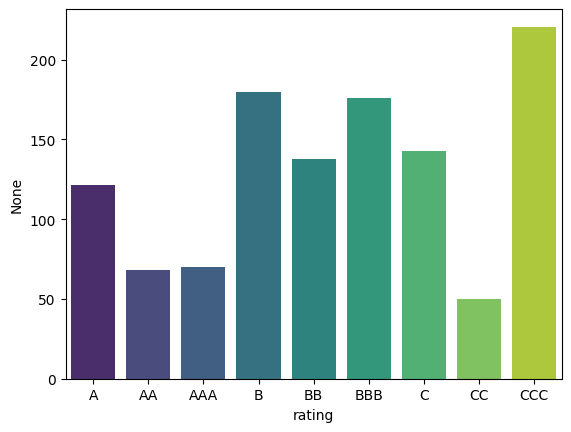

In [159]:
yy = df_grouped.mean_regcap_sum / df_grouped.num_bonds
sns.barplot(x='rating', y=yy, data=df_grouped, palette="viridis")

/var/folders/33/qv3yf4892xld1btchk4myrjc0000gn/T/ipykernel_33076/4096699501.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='proportion_rating', data=df_grouped, palette="viridis")


<Axes: xlabel='rating', ylabel='proportion_rating'>

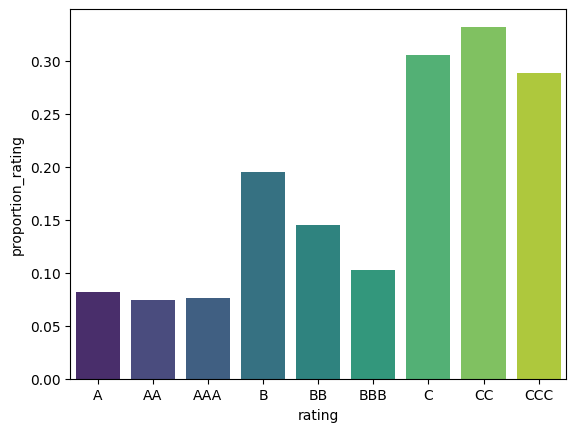

In [155]:
sns.barplot(x='rating', y='proportion_rating', data=df_grouped, palette="viridis")

The graph shows that bonds with CC rating contribute a lot to the total regulatory capital. For $1 exposure to CC bonds, $0.64 will be unexpected loss and thus needs to be set aside as regulatory capital. This result arises from the multiplicative effect of PD (which is mapped from ratings) and LGD (mapped from senority of the bonds).

In [161]:
median_regcap_for_each_bond = pd.DataFrame({
    'median_regcap': reg_cap_for_each_bond.apply(np.nanmedian, axis=1),
    'rating': bonds.rating})
df_grouped = median_regcap_for_each_bond.groupby('rating').median_regcap.agg(['sum', 'count'])
df_grouped.columns = ['median_regcap_sum', 'num_bonds']

df_grouped['EAD_rating'] = bonds.groupby('rating').EAD.sum()
df_grouped['EAD_total'] = bonds_ead

df_grouped['proportion_rating'] = df_grouped['median_regcap_sum'] / df_grouped.EAD_rating
df_grouped.head(n=10)

,median_regcap_sum,num_bonds,EAD_rating,EAD_total,proportion_rating
rating,,,,,
A,230516.924953,2152,3.199972e+06,9.417962e+06,0.072037
AA,21562.159401,330,3.006053e+05,9.417962e+06,0.071729
AAA,3982.343436,57,5.205224e+04,9.417962e+06,0.076507
B,27583.843471,153,1.410923e+05,9.417962e+06,0.195502
BB,57674.540546,426,4.057554e+05,9.417962e+06,0.142141
BBB,480982.787283,3069,5.263139e+06,9.417962e+06,0.091387
C,441.170552,3,1.401560e+03,9.417962e+06,0.314771
CC,102.649098,2,3.000100e+02,9.417962e+06,0.342152
CCC,15909.210861,70,5.364360e+04,9.417962e+06,0.296572


/var/folders/33/qv3yf4892xld1btchk4myrjc0000gn/T/ipykernel_33076/4096699501.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='proportion_rating', data=df_grouped, palette="viridis")


<Axes: xlabel='rating', ylabel='proportion_rating'>

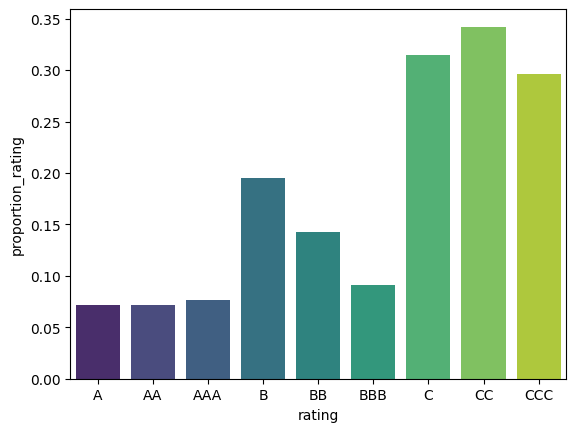

In [162]:
sns.barplot(x='rating', y='proportion_rating', data=df_grouped, palette="viridis")